<a href="https://www.kaggle.com/code/velimirkovacic/mn-0036533917-time-series-ts?scriptVersionId=183363511" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Time-series (TS)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import warnings  
from prophet import Prophet
from scipy.fft import fft, fftfreq



warnings.filterwarnings('ignore')  


First we will import the train dataset created in the first notebook.


In [2]:
df_train = pd.read_csv("../input/train-set-za-biljeznicu-2/train2.csv", parse_dates=["Date"], index_col="Date")
#df_train['Date'] = pd.to_datetime(df_train['Date'])

df_test = pd.read_csv("../input/dapprojekt24-1/test.csv", parse_dates=["Date"])
#df_train



## 1. Data preparation

This is the function from the 1st notebook for stock visualization. It is slightly modified.

In [3]:
def visualize_stock(symbol):
    stock = df_train["Symbol"] == symbol

    fig, ax = plt.subplots(1, 1, figsize=(14, 6))

    for col in ["Open", "Close", "Low", "High"]:
        ax.plot(df_train[stock][col], label=col)
    ax.set_title("Plot of stock " + symbol)
    ax.set_xlabel("Date")
    #ax.set_xticklabels(df_train[stock]["Date"][:length], rotation=45)
    ax.set_ylabel("Price")
    ax.legend()

    plt.tight_layout()
    plt.show()

#visualize_stock("MMM", 50)

### 1.1 Seasonality Check

We will perform a seasonality check on the feature "Adj Close" for all stocks. The strenght of seasonality is deduced using this formula:

$F_S = \max\left(0, 1 - \frac{\text{Var}({R_t})}{\text{Var}({T_t + R_t})}\right)$

Values closer to 1 indicate a strong seasonality and values closer to 0 indicate no seasonality.

In order to perform seasonal decomposition, the date range must not be missing values and there must not be NaN values. We will ensure this by filling the missing date indexes and linearly interpolating the values. 


In [4]:

def seasonality_check(symbol, period=365):
    df_stock = df_train[df_train["Symbol"] == symbol]
    
    if len(df_stock) < 2 * period: return 0
    
    full_date_range = pd.date_range(start=df_stock.index.min(), end=df_stock.index.max(), freq='B')
    df_stock = df_stock.reindex(full_date_range)

    df_stock["Adj Close"] = df_stock["Adj Close"].interpolate(method="linear")
    df_stock["Adj Close"] = (df_stock["Adj Close"] - df_stock["Adj Close"].min()) / (df_stock["Adj Close"].max() - df_stock["Adj Close"].min())
    
    decomposition = sm.tsa.seasonal_decompose(df_stock["Adj Close"], model='additive', period=period)
    
    residual_var = decomposition.resid.var()
    resid_season_var = (decomposition.resid + decomposition.seasonal).var()
    seasonality_strength = max(0, 1 - residual_var/resid_season_var)
    
    
    return seasonality_strength



### 1.2 Finding the Stock with the Highest Seasonality

We will find the stock with the highest seasonality strength and its period.

In [5]:
for period in [7, 365//12, 365//4, 365//2, 365]:
    max_val = 0
    max_symb = ""
    for symbol in df_train["Symbol"].unique():
        val = seasonality_check(symbol, period)
        if val > max_val:
            max_val = val
            max_symb = symbol
    
    print("Maximum seasonality\nPeriod:", period, "\nSymbol:", max_symb, "\nSeasonality strength:", max_val, "\n")

Maximum seasonality
Period: 7 
Symbol: FOXA 
Seasonality strength: 0.03491430868191481 

Maximum seasonality
Period: 30 
Symbol: CTVA 
Seasonality strength: 0.4380893558917346 

Maximum seasonality
Period: 91 
Symbol: FOXA 
Seasonality strength: 0.8675888345751857 

Maximum seasonality
Period: 182 
Symbol: INVH 
Seasonality strength: 0.36951254398821143 

Maximum seasonality
Period: 365 
Symbol: INVH 
Seasonality strength: 0.9336700622143237 



In [6]:
print("INVH", len(df_train[df_train["Symbol"] == "INVH"]))
print("CTVA", len(df_train[df_train["Symbol"] == "CTVA"]))
print("FOXA", len(df_train[df_train["Symbol"] == "FOXA"]))


INVH 734
CTVA 153
FOXA 205


Our best result was with the stock **INVH**. But there is an issue, the stock has only 734 rows, this means that this method is biased towards stocks with fewer rows. Also, we can see that the larger the period, the larger the strenght will be, this also makes sense, so we will just use the yearly period. We will run this experiment again but only with stocks that have the maximum (2507) number of rows.

In [7]:
for period in [7, 365//12, 365//4, 365//2, 365]:
    max_val = 0
    max_symb = ""
    for symbol in df_train["Symbol"].unique():
        if len(df_train[df_train["Symbol"] == symbol]) < 2507: continue

        val = seasonality_check(symbol, period)
        if val > max_val:
            max_val = val
            max_symb = symbol
    
    print("Maximum seasonality\nPeriod:", period, "\nSymbol:", max_symb, "\nSeasonality strength:", max_val, "\n")

Maximum seasonality
Period: 7 
Symbol: INTC 
Seasonality strength: 0.012235602448618876 

Maximum seasonality
Period: 30 
Symbol: TGT 
Seasonality strength: 0.04485261711342403 

Maximum seasonality
Period: 91 
Symbol: DHI 
Seasonality strength: 0.15586804814905153 

Maximum seasonality
Period: 182 
Symbol: IFF 
Seasonality strength: 0.24154087333886654 

Maximum seasonality
Period: 365 
Symbol: DUK 
Seasonality strength: 0.4106447547668377 



We can now see that the stock with the highest seasonality strength is **DUK**. The strength is much lower than that of INVH, but as we already saw, that is due to the number of rows which are decomposed.

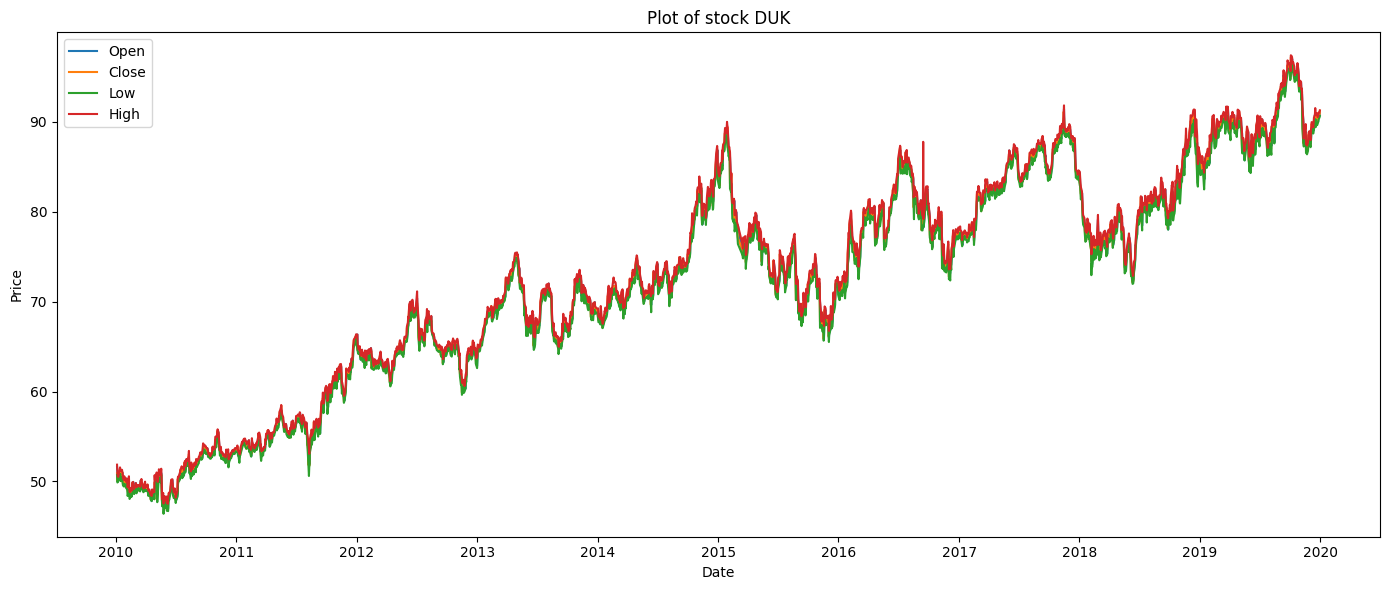

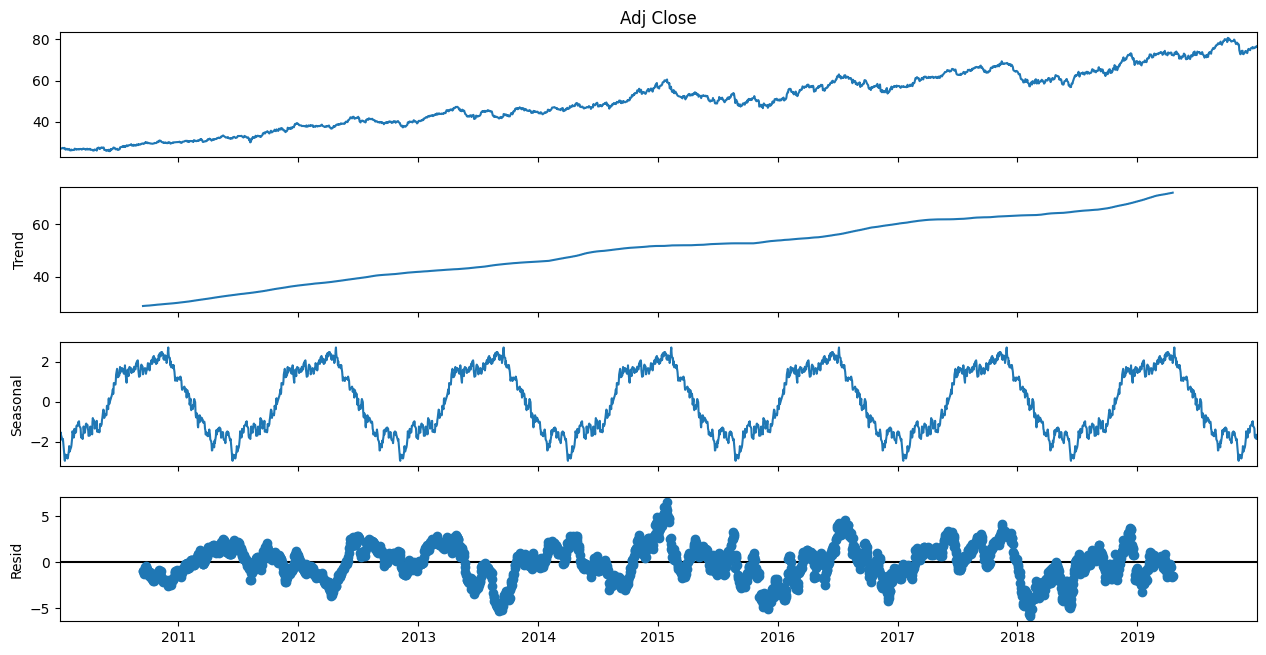

In [8]:
visualize_stock("DUK")

df_stock = df_train[df_train["Symbol"] == "DUK"]

full_date_range = pd.date_range(start=df_stock.index.min(), end=df_stock.index.max(), freq='B')
df_stock = df_stock.reindex(full_date_range)
df_stock = df_stock.interpolate(method="linear")
decomposition = sm.tsa.seasonal_decompose(df_stock["Adj Close"], model='additive', period=365)
    

fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

## 2. Exponential Smoothing
### 2.1 Baseline Model
We will attempt to use exponential smoothing to predict the future values of the Adj Close timeseries for our most seasonal stock "DUK".

In [9]:
length_train = round(len(df_stock) * 0.7)
length_test = len(df_stock) - length_train

train = df_stock["Adj Close"][:length_train]
test = df_stock["Adj Close"][length_train:]

model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=365
).fit()

predicted = model.forecast(steps=length_test)


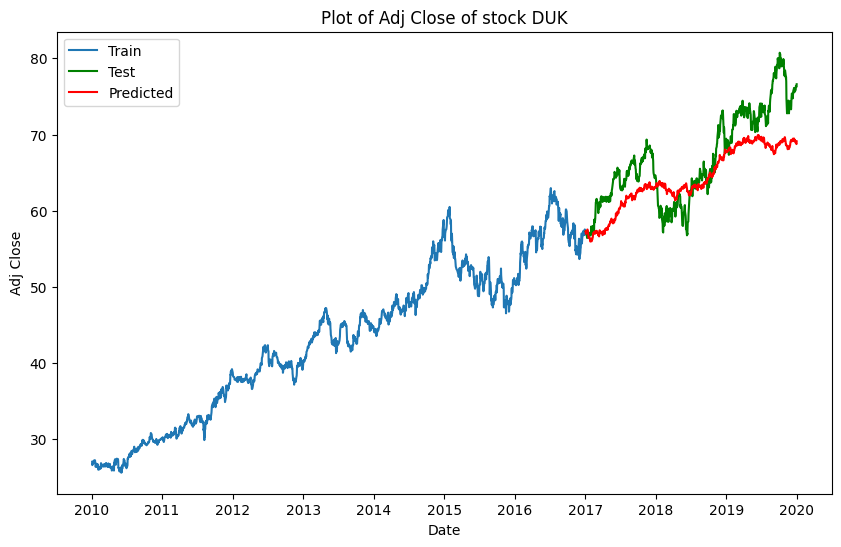

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='green')
plt.plot(predicted, label='Predicted', color='red')
plt.legend(loc='best')
plt.title("Plot of Adj Close of stock DUK")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.show()

We got a prediction which in a way does follow the rising and falling of Adj Close, however it is not a perfect prediction by any means. It could only be useful in predicting the seasonal rises and falls of the value.

We will calculate the root of MSE and MAE.

In [11]:
rmse = np.sqrt(mean_squared_error(test, predicted))
mae = mean_absolute_error(test, predicted)

print("RMSE:", rmse)
print("MAE", mae)

RMSE: 4.340671107826206
MAE 3.5790411564993776


### 2.2 Parameter Optimization

Exponential Smoothing model has a few parameters which could be optimized in order to get a better prediction:

* trend: “add”, “mul”
* damped_trend: True, False
* seasonal: “add”, “mul”
* seasonal_periods: 2, 4, 7, 365
* initialization_method: None, "estimated", "heuristic" ...
* use_boxcox: True, False

In [12]:
best_rmse = np.inf

best_damped_trend = True
best_seasonal_periods = 2
best_init_method = None
best_boxcox = True
best_model = None

df_gridsearch = pd.DataFrame(columns=['damped_trend', 'seasonal_periods', 'init_method', 'use_boxcox', 'RMSE', 'MAE'])

for damped_trend in [True, False]:
    for seasonal_periods in [2, 4, 7, 365]:
        for init_method in [None, "estimated", "heuristic"]:
            for use_boxcox in [True, False]:
                model = ExponentialSmoothing(
                    train,
                    trend='add',
                    seasonal='add',
                    seasonal_periods = seasonal_periods,
                    initialization_method = init_method,
                    damped_trend = damped_trend,
                    use_boxcox = use_boxcox
                ).fit()

                predicted = model.forecast(steps=length_test)
                
                rmse = np.sqrt(mean_squared_error(test, predicted))
                mae = mean_absolute_error(test, predicted)
                
                row = [damped_trend, seasonal_periods, init_method, use_boxcox, rmse, mae]

                df_gridsearch.loc[len(df_gridsearch)]=row
                #df_gridsearch = pd.concat([df_gridsearch, pd.DataFrame(row, columns=['damped_trend', 'seasonal_periods', 'init_method', 'use_boxcox', 'RMSE', 'MAE'])], ignore_index=True)
                
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_damped_trend = damped_trend
                    best_seasonal_periods = seasonal_periods
                    best_init_method = init_method
                    best_boxcox = use_boxcox
                    best_model = model
                    
                    
print("Best model:")
print("Damped trend =", best_damped_trend)
print("Seasonal periods =", best_seasonal_periods)
print("Init method =", best_init_method)
print("Boxcox =", best_boxcox)




predicted = best_model.forecast(steps=length_test)

rmse = np.sqrt(mean_squared_error(test, predicted))
mae = mean_absolute_error(test, predicted)

print("RMSE:", rmse)
print("MAE", mae)



Best model:
Damped trend = False
Seasonal periods = 4
Init method = heuristic
Boxcox = True
RMSE: 3.532857954124057
MAE 3.001563971775403


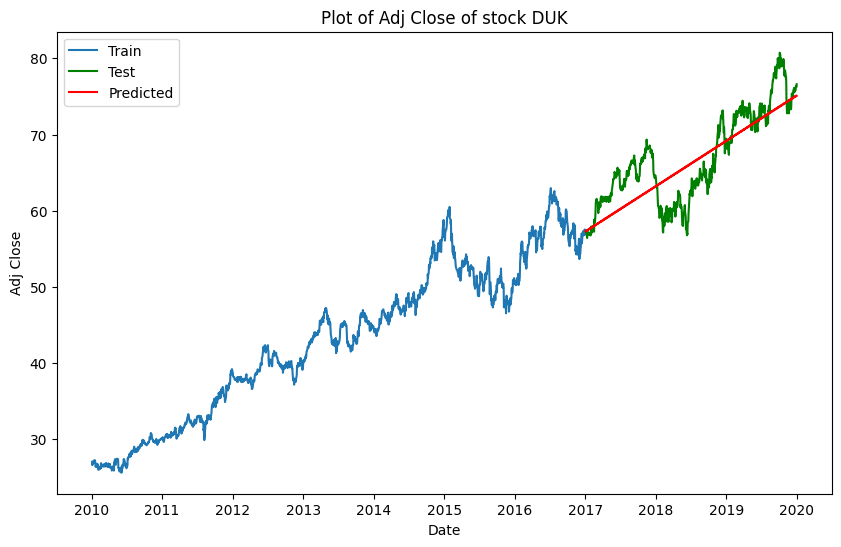

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='green')
plt.plot(predicted, label='Predicted', color='red')
plt.legend(loc='best')
plt.title("Plot of Adj Close of stock DUK")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.show()

It appears that the best model is the one that uses a quarterly period, heuristic initialization method and Boxcox. And it just predicts a straight line which minimizes RMSE and that is quite funny.

The line does follow the trend although it would not useful in "day-trading" because it does not predict the rising and falling of prices. 

A table of the parameters used and the errors obtained using these parameters:

In [14]:
df_gridsearch

,damped_trend,seasonal_periods,init_method,use_boxcox,RMSE,MAE
0,True,2,None,True,11.244320,9.492040
1,True,2,None,False,11.244527,9.492263
2,True,2,estimated,True,11.291037,9.542941
3,True,2,estimated,False,11.291067,9.542974
4,True,2,heuristic,True,11.287935,9.539540
5,True,2,heuristic,False,11.288019,9.539632
6,True,4,None,True,11.276807,9.527489
7,True,4,None,False,11.277017,9.527719
8,True,4,estimated,True,11.288437,9.540078
9,True,4,estimated,False,11.288103,9.539739


## 3. ARIMA
### 3.1 Baseline ARIMA

Here, we will attempt to use the ARIMA model with parameters (0,0,0)

In [15]:
def display_arima(model):
    plt.figure(figsize=(10, 6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test', color='green')
    plt.plot(predicted, label='Predicted', color='red')

    conf_int = model.get_forecast(length_test).conf_int(alpha=0.05)
    plt.fill_between(conf_int.index, conf_int['lower Adj Close'], conf_int['upper Adj Close'], color='k', alpha=0.1);

    plt.legend(loc='best')
    plt.title("Plot of Adj Close of stock DUK")
    plt.xlabel("Date")
    plt.ylabel("Adj Close")
    plt.show()

RMSE: 24.42688751754636
MAE 23.66201769271864


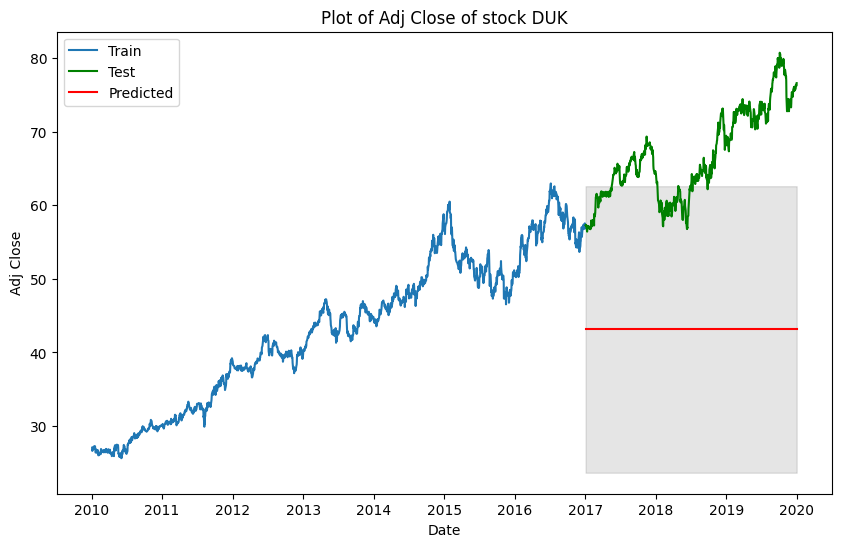

In [16]:
model = ARIMA(train, order=(0,0,0)).fit()

predicted = model.forecast(length_test)

rmse = np.sqrt(mean_squared_error(test, predicted))
mae = mean_absolute_error(test, predicted)

print("RMSE:", rmse)
print("MAE", mae)

display_arima(model)

The model with parameters (0,0,0) has given us a completely useless prediction. We can see that most of the values aren't even in the 95% confidence interval.

### 2.2 Paramter optimization (p, 0, 0)

In [17]:
df_gridsearch = pd.DataFrame(columns=['p', 'd', 'q', 's', 'RMSE', 'MAE'])


for p in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    model = ARIMA(train, order=(p,0,0)).fit()

    predicted = model.forecast(length_test)

    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    
    row = [p, 0, 0, None, rmse, mae]
    df_gridsearch.loc[len(df_gridsearch)]=row

    
    print("p =", p, "RMSE =", rmse)

p = 0 RMSE = 24.42688751754636
p = 1 RMSE = 16.259563471159147
p = 2 RMSE = 16.23702937301351
p = 3 RMSE = 16.068728024344633
p = 4 RMSE = 14.146339112244656
p = 5 RMSE = 14.169450039415791
p = 6 RMSE = 16.065445447160617
p = 7 RMSE = 16.418944765531208
p = 8 RMSE = 16.455092957279817
p = 9 RMSE = 16.234074517730534
p = 10 RMSE = 16.289114418012282


We get the lowest error for p = 4. We will train such a model and display the it's predictions.

RMSE: 14.146339112244656
MAE 12.157873329569858


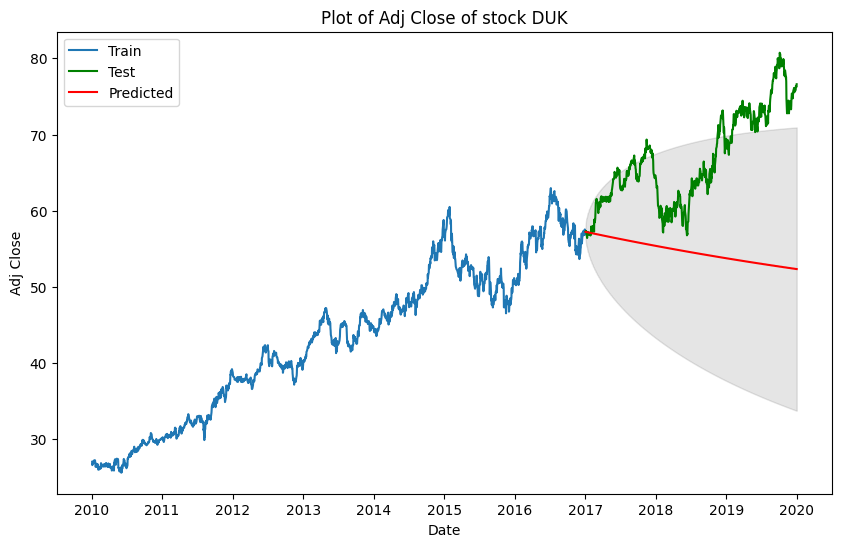

In [18]:
model = ARIMA(train, order=(4,0,0)).fit()

predicted = model.forecast(length_test)

rmse = np.sqrt(mean_squared_error(test, predicted))
mae = mean_absolute_error(test, predicted)

print("RMSE:", rmse)
print("MAE", mae)

display_arima(model)

The line is now skewed (p affects the angle of the line) and the 95% confidence interval is parabolic. More real values fall within it now.

### 3.3 Parameter optimization (0, d, 0)

In [19]:
for d in [0, 1, 2, 3, 4, 5]:
    model = ARIMA(train, order=(0,d,0)).fit()

    predicted = model.forecast(length_test)

    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    
    row = [0, d, 0, None, rmse, mae]
    df_gridsearch.loc[len(df_gridsearch)]=row
    
    print("d =", d, "RMSE =", rmse)

d = 0 RMSE = 24.42688751754636
d = 1 RMSE = 11.297975046687025
d = 2 RMSE = 144.10090843999143
d = 3 RMSE = 140769.63616469034
d = 4 RMSE = 63438168.09942808
d = 5 RMSE = 18081529018.554577


The lowest error was when d was equal to 1, after that the values explode.

RMSE: 11.297975046687025
MAE 9.550626905982757


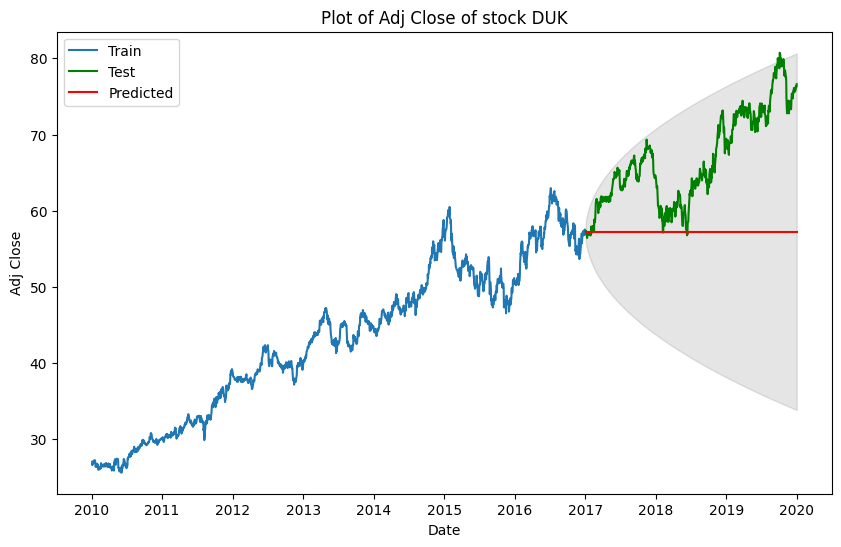

In [20]:
model = ARIMA(train, order=(0,1,0)).fit()

predicted = model.forecast(length_test)

rmse = np.sqrt(mean_squared_error(test, predicted))
mae = mean_absolute_error(test, predicted)

print("RMSE:", rmse)
print("MAE", mae)

display_arima(model)

It appears that d shifts the line. Most of the values are in the 95% confidence interval

### 3. Parameter optimization (0,0,q)

In [21]:
for q in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    model = ARIMA(train, order=(0,0,q)).fit()

    predicted = model.forecast(length_test)

    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    
    row = [0, 0, q, None, rmse, mae]
    df_gridsearch.loc[len(df_gridsearch)]=row
    
    print("q =", q, "RMSE =", rmse)

q = 0 RMSE = 24.42688751754636
q = 1 RMSE = 24.42603471756748
q = 2 RMSE = 24.423777676581924
q = 3 RMSE = 24.419698600557215
q = 4 RMSE = 24.416608757381375
q = 5 RMSE = 24.414288489566875
q = 6 RMSE = 24.414316285815477
q = 7 RMSE = 24.40534789508259
q = 8 RMSE = 24.405883595653826
q = 9 RMSE = 24.404580193312032
q = 10 RMSE = 24.416713334696855


The lowest error was for q = 9.

RMSE: 24.404580193312032
MAE 23.60225989882362


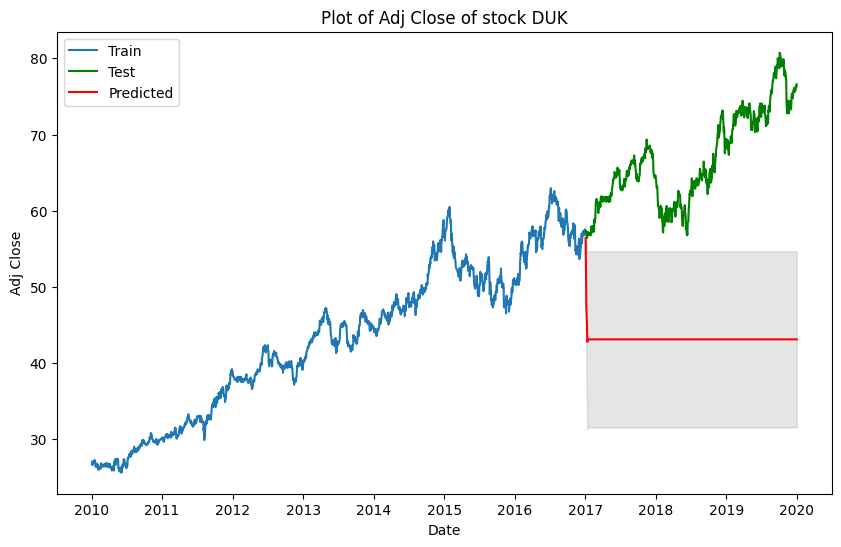

In [22]:
model = ARIMA(train, order=(0,0,9)).fit()

predicted = model.forecast(length_test)

rmse = np.sqrt(mean_squared_error(test, predicted))
mae = mean_absolute_error(test, predicted)

print("RMSE:", rmse)
print("MAE", mae)

display_arima(model)

It would be difficult to explain what happened here.

### 3.4 Parameter optimization (p,q,d)

In [23]:
best_triple = (0,0,0)
best_rmse = np.inf

for p in [1,2,3,4, 5]:
    for d in [1,2,3,4]:
        for q in [1,2,3,4, 5]:
            model = ARIMA(train, order=(p,d,q)).fit()

            predicted = model.forecast(length_test)

            rmse = np.sqrt(mean_squared_error(test, predicted))
            mae = mean_absolute_error(test, predicted)
    
            row = [p, d, q, None, rmse, mae]
            df_gridsearch.loc[len(df_gridsearch)]=row
            
            if rmse  < best_rmse:
                best_rmse = rmse
                best_triple = (p,d,q)

print(best_triple, "RMSE =", best_rmse)

(4, 2, 4) RMSE = 4.769846969175506


The ARIMA model with the lowest RMSE is the one with the parameter triple (4,2,4).

RMSE: 4.769846969175506
MAE 4.078296052838681


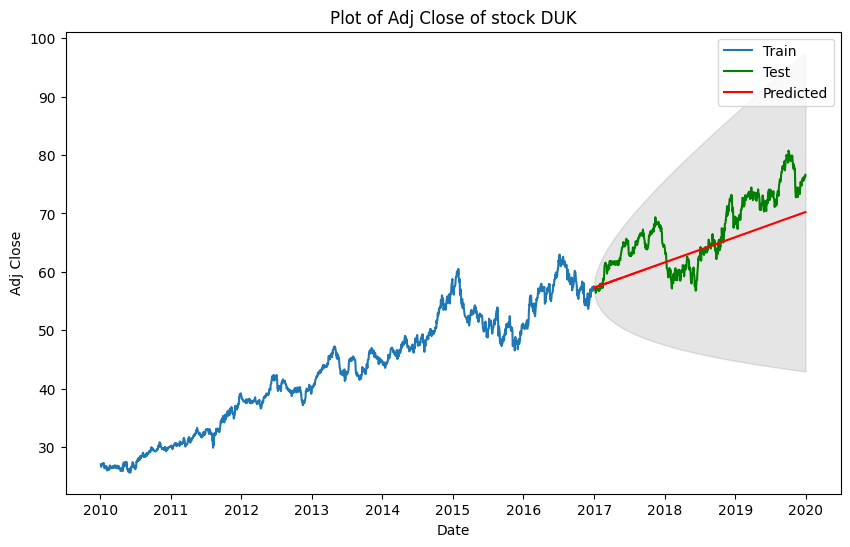

In [24]:
model = ARIMA(train, order=(4,2,4)).fit()

predicted = model.forecast(length_test)

rmse = np.sqrt(mean_squared_error(test, predicted))
mae = mean_absolute_error(test, predicted)

print("RMSE:", rmse)
print("MAE", mae)

display_arima(model)

Once again we can see that the prediction minimizing the error is a linear function.

### 3.5 Parameter optimization (4,2,4,s)

In [25]:
for s in [2, 4, 7, 12]:
    model = ARIMA(train, seasonal_order=(4,2,4, s)).fit()

    predicted = model.forecast(length_test)

    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    
    row = [4, 2, 4, s, rmse, mae]
    df_gridsearch.loc[len(df_gridsearch)]=row
    
    print("s =", s, "RMSE =", rmse)

s = 2 RMSE = 4.628544195438844
s = 4 RMSE = 4.7839802782489285
s = 7 RMSE = 4.7934030162782495
s = 12 RMSE = 3.8847842784681856


The lowest RMSE was achieved for s = 12.

RMSE: 3.8847842784681856
MAE 3.3765834804586876


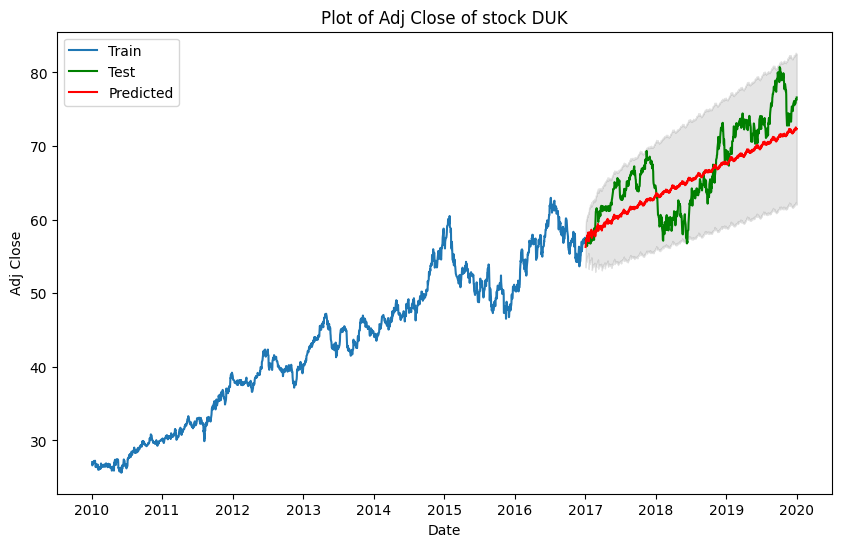

In [26]:
model = ARIMA(train, seasonal_order=(4,2,4,12)).fit()

predicted = model.forecast(length_test)

rmse = np.sqrt(mean_squared_error(test, predicted))
mae = mean_absolute_error(test, predicted)

print("RMSE:", rmse)
print("MAE", mae)

display_arima(model)

The result is a more jagged line and a slightly lower error.

A table of the parameters used and the errors obtained using these parameters:

In [27]:
df_gridsearch

,p,d,q,s,RMSE,MAE
0,0.0,0.0,0.0,NaN,24.426888,23.662018
1,1.0,0.0,0.0,NaN,16.259563,14.152526
2,2.0,0.0,0.0,NaN,16.237029,14.129918
3,3.0,0.0,0.0,NaN,16.068728,13.970731
4,4.0,0.0,0.0,NaN,14.146339,12.157873
...,...,...,...,...,...,...
127,5.0,4.0,5.0,NaN,209.312013,170.435966
128,4.0,2.0,4.0,2.0,4.628544,3.972830
129,4.0,2.0,4.0,4.0,4.783980,4.089297
130,4.0,2.0,4.0,7.0,4.793403,4.094441


## 4. Facebook Prophet

### 4.1 Baseline Model

Here we will create a Facebook Prophet model four our stock DUK.

In [28]:
df_fb = df_stock.reset_index()
df_fb = df_fb.rename(columns={'Adj Close': 'y', 'index': 'ds'})



length_train = round(len(df_fb) * 0.7)
length_test = len(df_fb) - length_train

train = df_fb[:length_train]
test = df_fb[length_train:]

model = Prophet()

model.fit(train)


predicted = model.predict(test.drop(columns=["y"]))

rmse = np.sqrt(mean_squared_error(test["y"], predicted["yhat"]))
mae = mean_absolute_error(test["y"], predicted["yhat"])

print("RMSE:", rmse)
print("MAE", mae)

19:56:33 - cmdstanpy - INFO - Chain [1] start processing
19:56:35 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 6.893005577468442
MAE 5.761026788048207


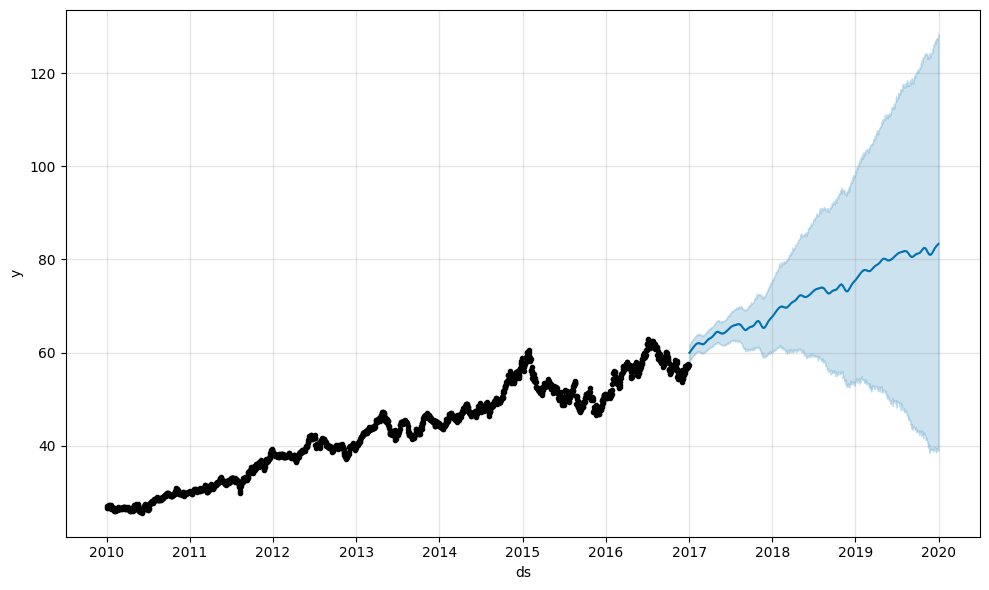

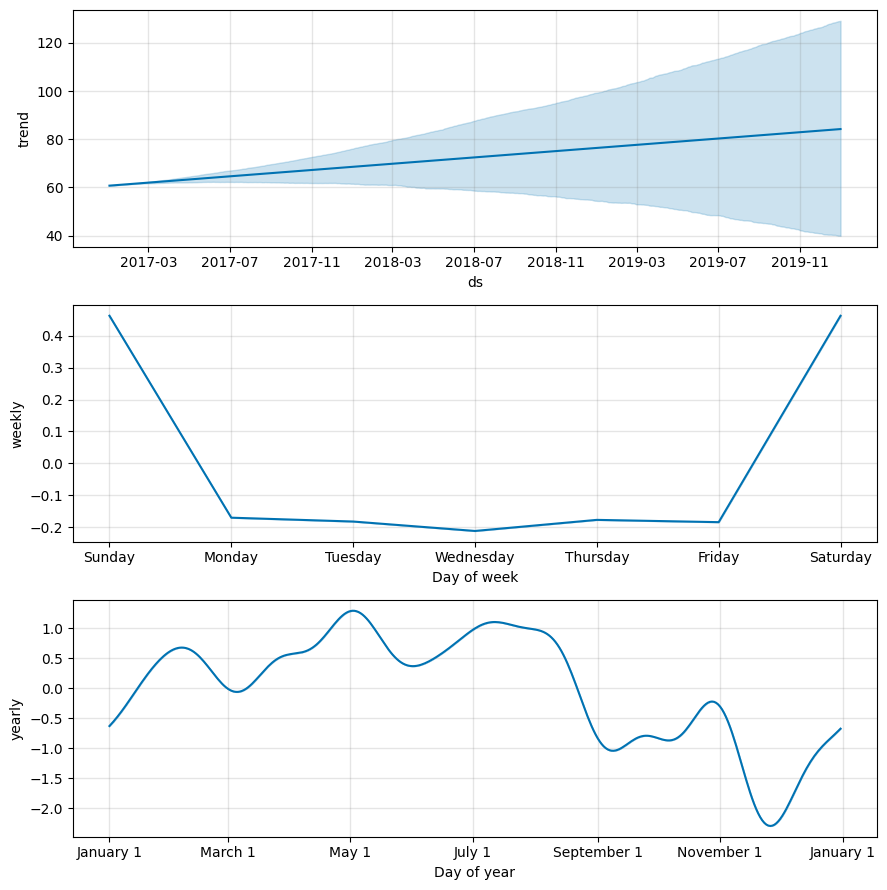

In [29]:
model.plot(predicted)
plt.show()
model.plot_components(predicted)
plt.show()

An interesting prediction, but it does not predict the drops, it mostly keeps growing.

### 4.2 Model with adjusted seasonality

We define a yearly seasonality and and search for the best fourier order. We will add market crashes from 2010 to 2020 as holidays to improve our model.

* May 6, 2010 (Flash Crash)
* Aug. 1, 2011 (stock markets fall)
* June 12,  2015 (Chinese stock market crash)
* Aug. 18, 2015 (stock market selloff)
* Sep. 20, 2018 (cryptocurrency crash)
* Feb. 24, 2020 (COVID-19 Crash)

In [30]:
crash_dates = ['2010-05-06', '2011-08-01', '2015-06-12', '2015-08-18', '2018-09-20', '2020-02-24']
holidays = pd.DataFrame({
    'holiday': 'stock_market_crash',
    'ds': pd.to_datetime(crash_dates),
    'lower_window': 0,
    'upper_window': 5,
})

In [31]:
bst_rmse = np.inf
fo_best = 1
df_gridsearch = pd.DataFrame(columns=['fourier_order', 'period', 'seasonality', 'RMSE', 'MAE'])


for fourier_order in range(1, 20):
    model = Prophet(holidays=holidays)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=fourier_order)
    model.fit(train)
    predicted = model.predict(test.drop(columns=["y"]))
    rmse = np.sqrt(mean_squared_error(test["y"], predicted["yhat"]))
    mae = mean_absolute_error(test["y"], predicted["yhat"])
    
    row = [fourier_order, 365.25, "yearly", rmse, mae]
    df_gridsearch.loc[len(df_gridsearch)]=row
    
    
    if rmse < best_rmse:
        best_rmse = rmse
        fo_best = fourier_order
    print("Fourier order:", fourier_order, "RMSE:", rmse)
    
print("Best fourier order", fo_best)

19:56:37 - cmdstanpy - INFO - Chain [1] start processing
19:56:38 - cmdstanpy - INFO - Chain [1] done processing
19:56:39 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 1 RMSE: 6.395722113508477


19:56:40 - cmdstanpy - INFO - Chain [1] done processing
19:56:40 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 2 RMSE: 6.654229707349999


19:56:42 - cmdstanpy - INFO - Chain [1] done processing
19:56:42 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 3 RMSE: 6.6511696737912


19:56:44 - cmdstanpy - INFO - Chain [1] done processing
19:56:44 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 4 RMSE: 6.883908838692902


19:56:45 - cmdstanpy - INFO - Chain [1] done processing
19:56:46 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 5 RMSE: 6.933111114600089


19:56:47 - cmdstanpy - INFO - Chain [1] done processing
19:56:48 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 6 RMSE: 6.896215686078568


19:56:49 - cmdstanpy - INFO - Chain [1] done processing
19:56:50 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 7 RMSE: 6.9481457414856145


19:56:51 - cmdstanpy - INFO - Chain [1] done processing
19:56:52 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 8 RMSE: 6.985309332492665


19:56:53 - cmdstanpy - INFO - Chain [1] done processing
19:56:54 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 9 RMSE: 6.900481054625964


19:56:55 - cmdstanpy - INFO - Chain [1] done processing
19:56:56 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 10 RMSE: 6.849717924222455


19:56:57 - cmdstanpy - INFO - Chain [1] done processing
19:56:58 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 11 RMSE: 6.8882536613050105


19:57:00 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 12 RMSE: 6.879638598351894


19:57:00 - cmdstanpy - INFO - Chain [1] start processing
19:57:02 - cmdstanpy - INFO - Chain [1] done processing
19:57:02 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 13 RMSE: 6.846381001142365


19:57:04 - cmdstanpy - INFO - Chain [1] done processing
19:57:05 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 14 RMSE: 6.859534439287675


19:57:06 - cmdstanpy - INFO - Chain [1] done processing
19:57:07 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 15 RMSE: 6.919807905602401


19:57:08 - cmdstanpy - INFO - Chain [1] done processing
19:57:09 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 16 RMSE: 6.85091645978583


19:57:10 - cmdstanpy - INFO - Chain [1] done processing
19:57:11 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 17 RMSE: 6.890122050771939


19:57:12 - cmdstanpy - INFO - Chain [1] done processing
19:57:13 - cmdstanpy - INFO - Chain [1] start processing


Fourier order: 18 RMSE: 6.911258786991606


19:57:14 - cmdstanpy - INFO - Chain [1] done processing


Fourier order: 19 RMSE: 6.847699299966711
Best fourier order 1


19:57:15 - cmdstanpy - INFO - Chain [1] start processing
19:57:16 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 6.395722113508477
MAE 5.263219713838123


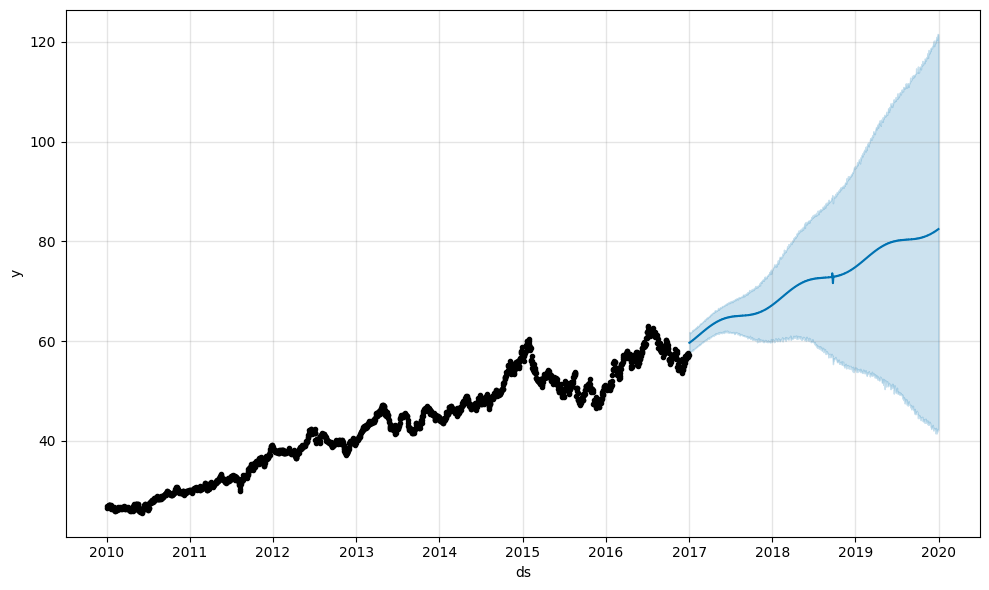

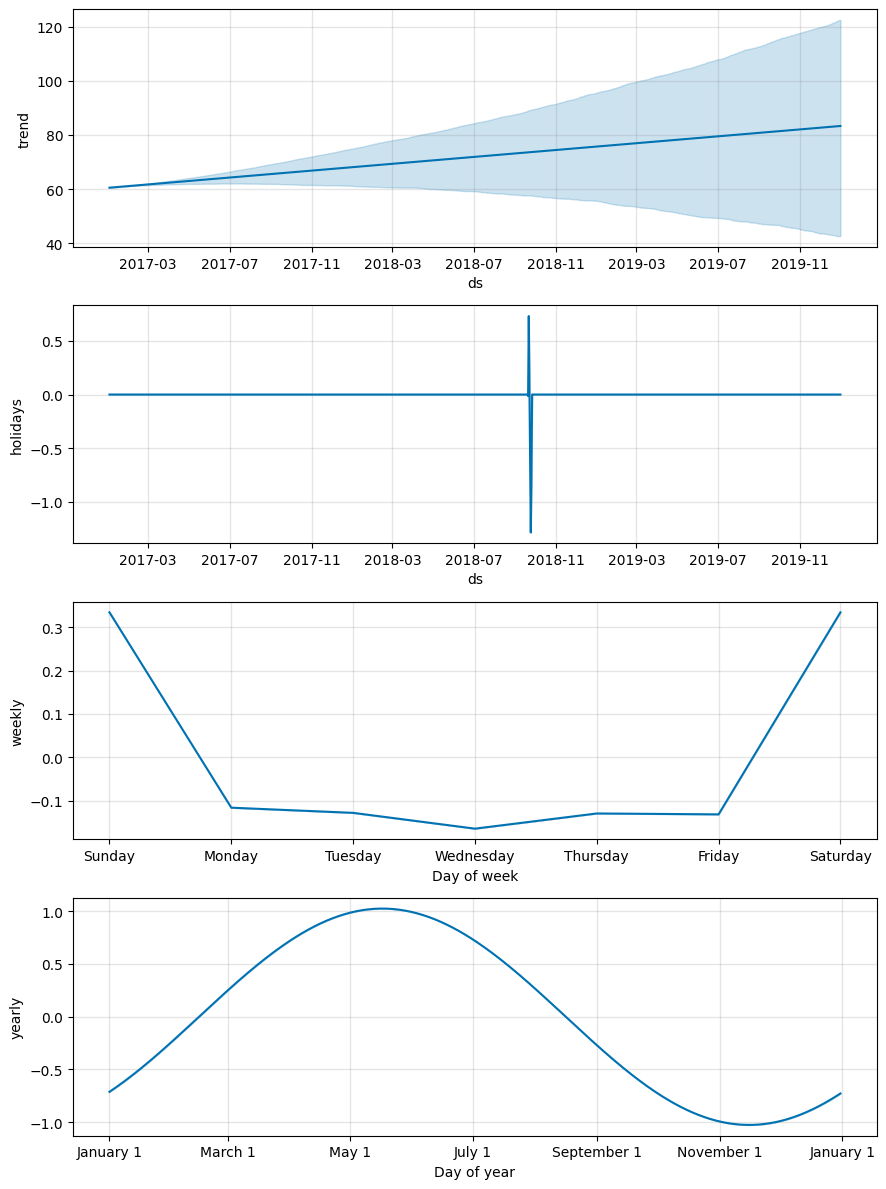

In [32]:
model = Prophet(holidays=holidays)
model.add_seasonality(name='yearly', period=365.25, fourier_order=fo_best)
model.fit(train)
predicted = model.predict(test.drop(columns=["y"]))
rmse = np.sqrt(mean_squared_error(test["y"], predicted["yhat"]))
mae = mean_absolute_error(test["y"], predicted["yhat"])

print("RMSE:", rmse)
print("MAE", mae)

model.plot(predicted)
plt.show()
model.plot_components(predicted)
plt.show()

We find that using a fourier order of 1 yields the best results. The error was slightly reduced but still higher than that of ARIMA and Exponential Smoothing.

A table of the parameters used and the errors obtained using these parameters:

In [33]:
df_gridsearch

,fourier_order,period,seasonality,RMSE,MAE
0,1,365.25,yearly,6.395722,5.263220
1,2,365.25,yearly,6.654230,5.523799
2,3,365.25,yearly,6.651170,5.515800
3,4,365.25,yearly,6.883909,5.755171
4,5,365.25,yearly,6.933111,5.801848
5,6,365.25,yearly,6.896216,5.765626
6,7,365.25,yearly,6.948146,5.813629
7,8,365.25,yearly,6.985309,5.847300
8,9,365.25,yearly,6.900481,5.769733
9,10,365.25,yearly,6.849718,5.721518


## 5. RandomForestRegressor

Here we will use the RandomForestRegressor to predict the day's Adj Close value based on all previous day's values.

In [34]:
trainX, trainY = df_stock.drop(columns=["Symbol", "Target", "Id"])[:length_train - 1], df_stock["Adj Close"][1:length_train]
testX, testY = df_stock.drop(columns=["Symbol", "Target", "Id"])[length_train:-1], df_stock["Adj Close"][length_train+1:]

In [35]:
model = RandomForestRegressor()
model.fit(trainX, trainY)
predY = model.predict(testX)

rmse = np.sqrt(mean_squared_error(testY, predY))
mae = mean_absolute_error(testY, predY)

print("RMSE:", rmse)
print("MAE", mae)


RMSE: 7.700282714115908
MAE 5.761066944547255


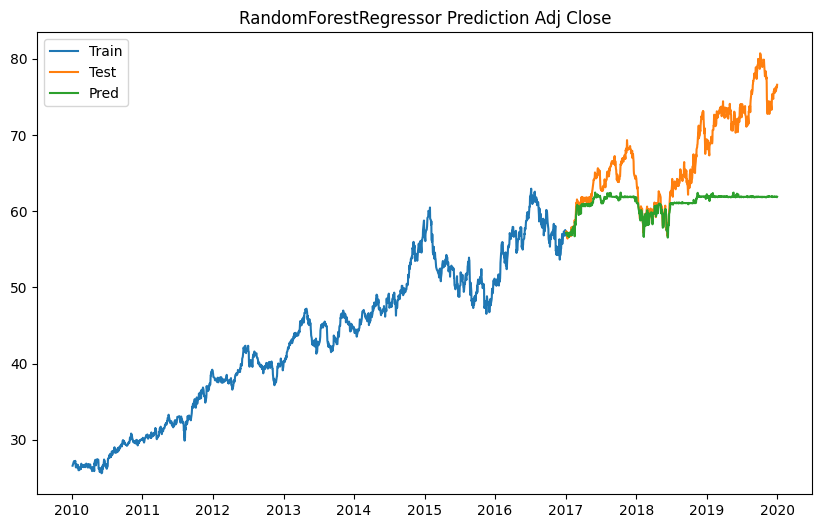

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(trainY, label="Train")
plt.plot(testY, label="Test")
plt.plot(testY.index, predY, label="Pred")
plt.title("RandomForestRegressor Prediction Adj Close")
plt.legend()
plt.show()

The results seem to be worse. The model does not follow the trend at all. It is a different way of predicting the value so it cannot be directly compared to the previous three methods.

## 6. Generated signal

Here we create a new signal and attempt to use all the previous methods on it.

### 6.1 Visualization

In [37]:
from scipy import signal
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 100 * t) 
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63) 
trend = np.linspace(0, 600, 600)/(165*np.pi)
trend1 = np.linspace(0, 100, 100)/(112*np.pi)
trend2 = np.linspace(0, 300, 300)/(-103*np.pi)
trend3 = np.linspace(0, 200, 200)/(148*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]


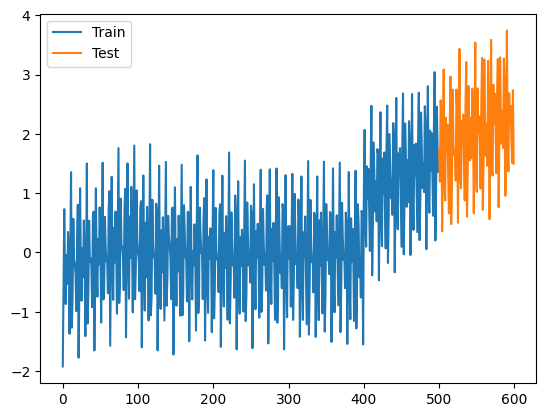

In [38]:
plt.plot(range(500), pts_train, label="Train")
plt.plot(range(500, 500+100), pts_test, label="Test")
plt.legend()
plt.show()

We can see that there is a linear trend which starts at index 400 and continues through to the test set. Before that it is not easily descernable what the trend is. The oscilations are caused by a pair of sawtooth functions.

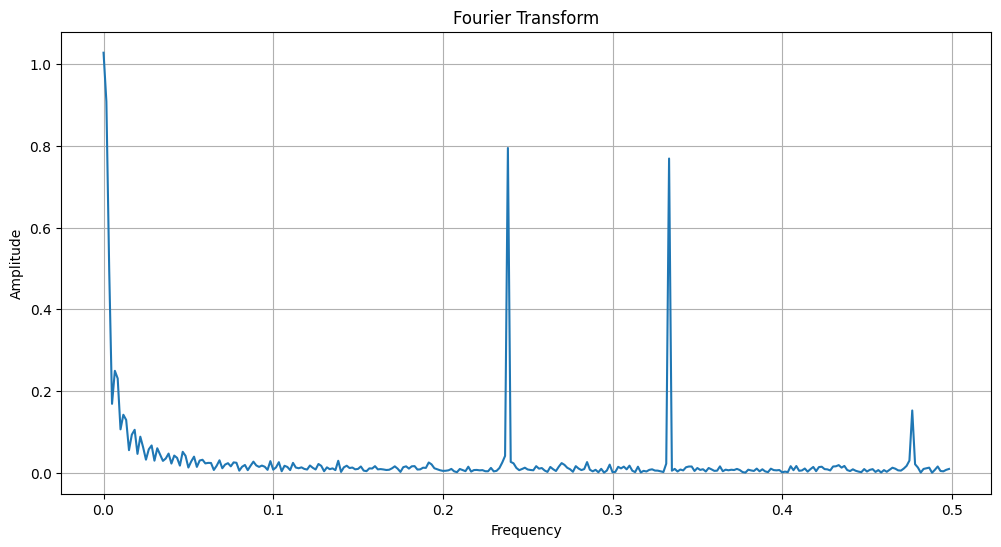

In [39]:
yf = fft(pts)
xf = fftfreq(last_n_rows, 1)[:last_n_rows//2]

plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/last_n_rows * np.abs(yf[0:last_n_rows//2]))
plt.title('Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()



Here in the fourier transformed version we can see that there are a couple of peek frequencies which we might be able to use as a period

In [40]:
peaks = np.argsort(2.0/last_n_rows * np.abs(yf[:last_n_rows//2]))[::-1]

print("Peaks occuring at:", peaks[1:10])

print("Dominant frequencies:", xf[peaks[1:10]])

periods = 1 / xf[peaks[1:10]]
periods = np.round(periods).astype(int)
print("Dominant periods:", periods)

Peaks occuring at: [  1 143 200   2   4   5   3 286   7]
Dominant frequencies: [0.00166667 0.23833333 0.33333333 0.00333333 0.00666667 0.00833333
 0.005      0.47666667 0.01166667]
Dominant periods: [600   4   3 300 150 120 200   2  86]


We will attempt to decompose for each of these periods and calculate the seasonality strength.

In [41]:
for period in periods[1:]:
    decomposition = sm.tsa.seasonal_decompose(pts, model='additive', period=period)
    residual_var = decomposition.resid.var()
    resid_season_var = (decomposition.resid + decomposition.seasonal).var()
    seasonality_strength = max(0, 1 - residual_var/resid_season_var)
    print("Period:", period, "Seasonality strength:", seasonality_strength)



Period: 4 Seasonality strength: 0
Period: 3 Seasonality strength: 0
Period: 300 Seasonality strength: 0
Period: 150 Seasonality strength: 0
Period: 120 Seasonality strength: 0
Period: 200 Seasonality strength: 0
Period: 2 Seasonality strength: 0
Period: 86 Seasonality strength: 0


Rather shamefully, none of these periods yield a seasonality strenght larger than 0. We will still attempt to decompose using a period of 4.

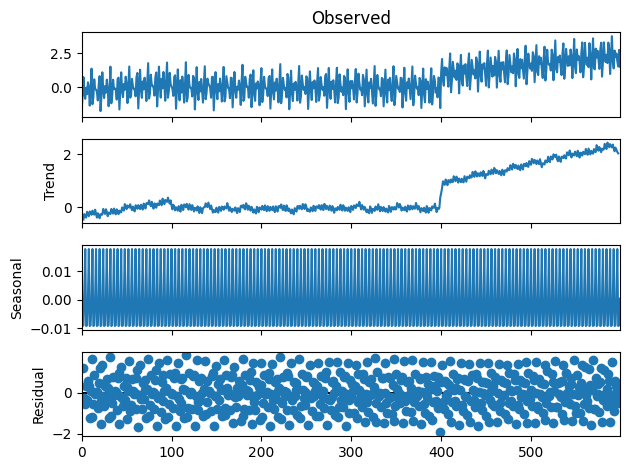

In [42]:
decomposition = sm.tsa.seasonal_decompose(pts, model='additive', period=4)
decomposition.plot()
plt.show()

### 6.2 Exponential smoothing

We will use exponential smoothing with parameter optimization on the singal.

In [43]:
best_rmse = np.inf

best_damped_trend = True
best_seasonal_periods = 2
best_init_method = None
best_model = None


for damped_trend in [True, False]:
    for seasonal_periods in [2, 3, 4, 7]:
        for init_method in [None, "estimated", "heuristic"]:
                model = ExponentialSmoothing(
                    pts_train,
                    trend='add',
                    seasonal='add',
                    seasonal_periods = seasonal_periods,
                    initialization_method = init_method,
                    damped_trend = damped_trend,
                ).fit()

                predicted = model.forecast(steps=100)
                
                rmse = np.sqrt(mean_squared_error(pts_test, predicted))
                
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_damped_trend = damped_trend
                    best_seasonal_periods = seasonal_periods
                    best_init_method = init_method
                    best_model = model
                    
                    
print("Best model:")
print("Damped trend =", best_damped_trend)
print("Seasonal periods =", best_seasonal_periods)
print("Init method =", best_init_method)




predicted = best_model.forecast(steps=100)

rmse = np.sqrt(mean_squared_error(pts_test, predicted))
mae = mean_absolute_error(pts_test, predicted)

print("RMSE:", rmse)
print("MAE", mae)


Best model:
Damped trend = False
Seasonal periods = 3
Init method = None
RMSE: 0.5953346288909062
MAE 0.5085812251398462


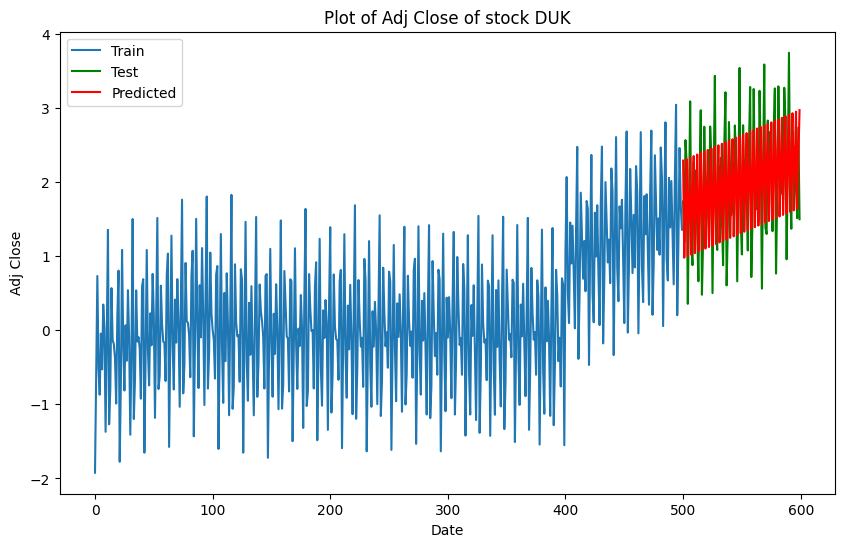

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(range(500), pts_train, label='Train')
plt.plot(range(500, 600), pts_test, label='Test', color='green')
plt.plot(range(500, 600), predicted, label='Predicted', color='red')
plt.legend(loc='best')
plt.title("Plot of Adj Close of stock DUK")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.show()

A seemingly alright prediciton. The trend is followed well and there are oscilations.

### 6.3 ARIMA

Here we will use ARIMA with parameter optimization.

In [45]:
best_triple = (0,0,0)
best_rmse = np.inf

for p in [1,2,3,4, 5]:
    for d in [1,2,3,4]:
        for q in [1,2,3,4, 5]:
            model = ARIMA(pts_train, order=(p,d,q)).fit()

            predicted = model.forecast(100)

            rmse = np.sqrt(mean_squared_error(pts_test, predicted))
            
            if rmse  < best_rmse:
                best_rmse = rmse
                best_triple = (p,d,q)

print(best_triple, "RMSE =", best_rmse)

(5, 2, 3) RMSE = 0.2918262305470307


In [46]:
for s in [2, 4, 7, 12]:
    model = ARIMA(pts_train, seasonal_order=(5,2,5, s)).fit()
    predicted = model.forecast(100)
    rmse = np.sqrt(mean_squared_error(pts_test, predicted))
            
    print("s =", s, "RMSE =", rmse)

s = 2 RMSE = 0.27203231373904363
s = 4 RMSE = 0.747909624970562
s = 7 RMSE = 0.30225252887370435
s = 12 RMSE = 0.32595338450776873


In [47]:
model = ARIMA(pts_train, seasonal_order=(5,2,5, 2)).fit()

predicted = model.forecast(100)

rmse = np.sqrt(mean_squared_error(pts_test, predicted))
mae = mean_absolute_error(pts_test, predicted)

print("RMSE:", rmse)
print("MAE", mae)



RMSE: 0.27203231373904363
MAE 0.17326569962374053


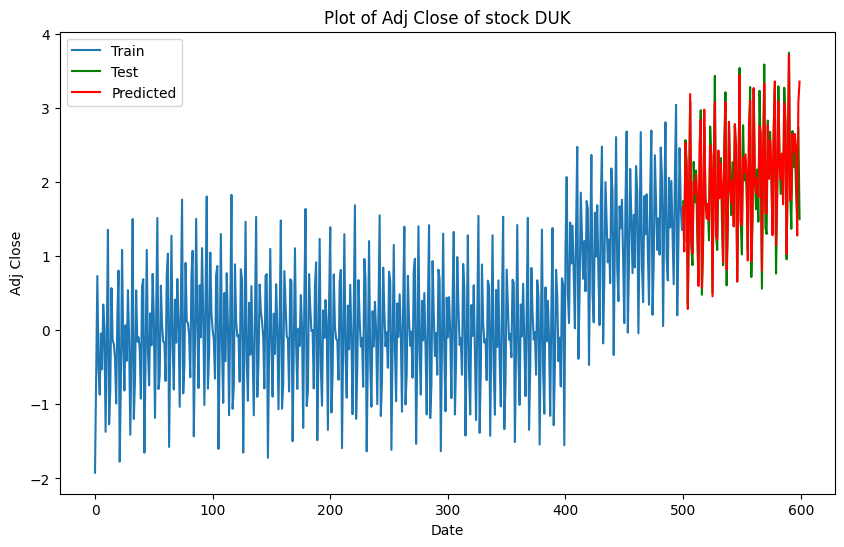

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(range(500), pts_train, label='Train')
plt.plot(range(500, 600), pts_test, label='Test', color='green')
plt.plot(range(500, 600), predicted, label='Predicted', color='red')
plt.legend(loc='best')
plt.title("Plot of Adj Close of stock DUK")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.show()

A much better prediction than Exponential Smoothing. Follows the trend and the oscilations seem to line up. The error is also lower.

### 6.4 Facebook Prophet

In [49]:
df_fb = pd.DataFrame({
    'ds': pd.date_range(start='2010-01-01', periods=500, freq='D'),
    'y': pts_train
})

df_fb_test = pd.DataFrame({
    'ds': pd.date_range(start=df_fb["ds"].iloc[-1] + pd.Timedelta(days=1), periods=100, freq='D'),
    'y': pts_test
})


20:01:44 - cmdstanpy - INFO - Chain [1] start processing
20:01:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.8615068150020652
MAE 0.7033495177386776


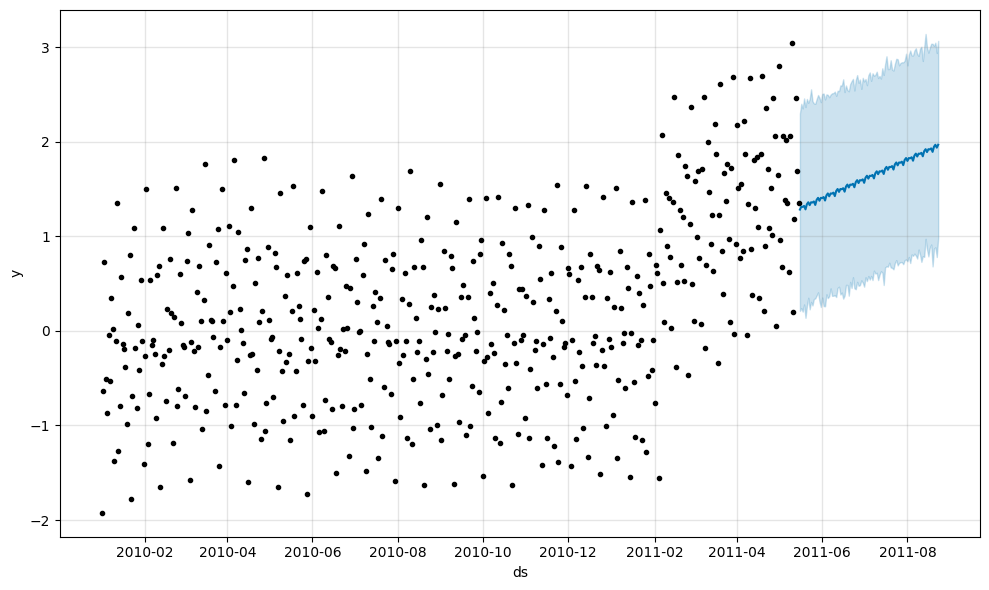

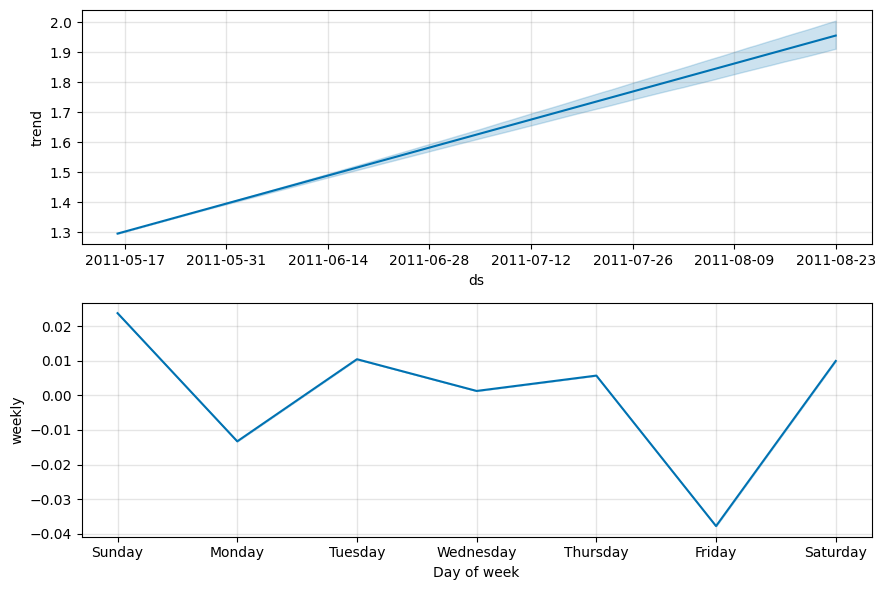

In [50]:
model = Prophet()
model.fit(df_fb)
predicted = model.predict(df_fb_test.drop(columns=["y"]))

rmse = np.sqrt(mean_squared_error(df_fb_test["y"], predicted["yhat"]))
mae = mean_absolute_error(df_fb_test["y"], predicted["yhat"])

print("RMSE:", rmse)
print("MAE", mae)

model.plot(predicted)
plt.show()
model.plot_components(predicted)
plt.show()

A worse prediction than both Exponential Smoothing and ARIMA. The trend is followed nevertheless.